# Modélisation de la propagation de l'épidémie du Covid : Simulation multi-agents

Auteur : Maxime Gatineau, Élève Ingénieur de l'[École Centrale de Lille](https://ecole.centralelille.fr/) <br/>
Tuteur : Philippe Mathieu, [CRIStAL Lab](https://www.cristal.univ-lille.fr/), [SMAC Team](https://www.cristal.univ-lille.fr/gt/i2c/) <br/>
Création : Septembre 2020

### Objectifs

Nous souhaitons modéliser à l’échelle microscopique l’évolution de l’épidémie du covid en France. <br/>
Notre but est de pouvoir faire des prévisions à court termes sur la propagation de l'épidémie et de sortir les paramètres qui impactent la force et la vitesse de la propagation.

### Principes

Un système multi-agents est un système dans lequel des entités dotées de leur propre comportement, intéragissent entre-elles. <br/>
Nos agents doivent représenter la population française, ils auront différentes caractéristiques, par exemple l'âge et le sexe. <br/>
Les agents seront reliés entre eux selon un modèle de Barabási-Albert, qui génére aléatoirement un réseau invariant d'échelle et qui permet de représenter un réseau social pour des interactions humaines. <br/>
Ensuite, sur un principe de tour de parole, nous allons interroger chaque agents, regarder leurs connexions et dire s'ils peuvent être contaminés par les agents qui les entourent. <br/>
Enfin, l'utilisation d'un algorithme génétique permettra d'accorder les paramètres avec les données que nous avons en France.

### Table des matières <a class="anchor" id="tdm"></a>

* [Chapitre 1 : Simulation](#c1)
    * [Partie 1 : Caractéristiques de la population française](#c1-p1)
    * [Partie 2 : Simulation multi-agents](#c1-p2)
    * [Partie 3 : Facteurs de contagion](#c1-p3)
    * [Partie 4 : Simulation avec une contagion aléatoire V1](#c1-p4)
    * [Partie 5 : Simulation avec une contagion aléatoire V2 (dépendance de l'âge)](#c1-p5)
    * [Partie 6 : Algorithme génétique](#c1-p6)
* [Chapitre 2 : Graphes](#c2)
    * [Partie 1 : Graphe de l'évolution du Covid en France](#c2-p1)
    * [Partie 2 : Répartion de la population française](#c2-p2)
    * [Partie 3 : Création d'une animation sur notre graphe social](#c2-p3)
* [Sources](#s)

### Librairies :

In [1]:
import numpy as np
import csv 
import random
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import sys
import time 
import glob
from datetime import date
from PIL import Image
import os

## Chapitre 1 : Simulation <a class="anchor" id="c1"></a>

### Partie 1 : Caractéristiques de la population française <a class="anchor" id="c1-p1"></a>

Explications : 

[Table des matières](#tdm)

Pour notre étude, les paramètres se basent sur les sources et s'implémentent de la manière suivante : 
* Pour l'âge : 
     * 0 = < 15 ans
     * 1 = entre 15 et 30 ans
     * 2 = entre 30 et 55 ans
     * 3 = > 55 ans
     
     
* Pour le sexe :
    * 0 = homme
    * 1 = femme


* Pour le poids :
    * 0 = Dénutrition (IMC < 18.5)
    * 1 = Normal (18.5 > IMC > 25)
    * 2 = Surpoids (25 > IMC > 30)
    * 3 = Obésité (IMC > 30)


* Pour le groupe sanguin : 
    * 0 = A+
    * 1 = O+
    * 2 = B+ 
    * 3 = AB+
    * 4 = A-
    * 5 = O-
    * 6 = B-
    * 7 = AB-

In [2]:
# Implémentation des paramètres sur une population

nb_agents = 7000
agentList = []
age=[]
sexe=[]
poids = []
groupe_sanguin = []

# Proportions cumulatives pour l'âge:
prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

# Par tranches d'âges les proportions normalisées sont :
prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

# Proportions cumulatives pour le poids :
prop_poids = [0.035,0.492,0.323,0.15]

# Proportions pour le groupe sanguin : 
prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

graph = nx.barabasi_albert_graph(nb_agents,1)
# Avec numpy array :
matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))

class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

# Initialize accointances based on the matrix
for i in range(nb_agents):
    agentList.append(Agent(i,np.nonzero(matrix[i])[0]))
    
for i in range(nb_agents):
    if 0 <= i <= int(nb_agents*prop_age[0]):
        age.append(0)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
    if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
        age.append(1)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
    if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
        age.append(2)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
    if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
        age.append(3)
        sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
    poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
    groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

In [3]:
# Analyse de nos valeurs :

print("Implémentation des paramètres\n")
print(f"Il y a {nb_agents} agents.")
# On regarde que les tableaux aient la même taille :
print(f"Les tableaux sont de la même taille que le nombre d'agents : {len(age) == len(poids) == len(sexe) == nb_agents}\n")
# On compare avec les valeurs réelles : 
y = np.bincount(age)/nb_agents
ii = np.nonzero(y)[0]
# On prends la proportion d'âge non-cumulative :
prop_age_nc = np.array(prop_age)
for i in range(0,len(prop_age)):
    if i == 0:
        prop_age_nc[i] = prop_age[i]
    else:
        prop_age_nc[i] = prop_age[i] - prop_age[i-1]
print(f"La proportion par tranches d'âge (simulation - réelle) est :\n{np.vstack((ii,y[ii],prop_age_nc[ii])).T}\n")

y = np.bincount(sexe)/nb_agents
ii = np.nonzero(y)[0]
print(f"La proportion H/F (simulation - réelle) est :\n{np.vstack((ii,y[ii])).T}\n")

y = np.bincount(poids)/nb_agents
ii = np.nonzero(y)[0]
prop_poids = np.array(prop_poids)
print(f"La proportion du poids (simulation - réelle) est de :\n{np.vstack((ii,y[ii],prop_poids[ii])).T}\n")

y = np.bincount(groupe_sanguin)/nb_agents
ii = np.nonzero(y)[0]
prop_groupe_sanguin = np.array(prop_groupe_sanguin)
print(f"La proportion pour les groupes sanguins (simulation - réelle) est de :\n{np.vstack((ii,y[ii],prop_groupe_sanguin[ii])).T}")

Implémentation des paramètres

Il y a 7000 agents.
Les tableaux sont de la même taille que le nombre d'agents : True

La proportion par tranches d'âge (simulation - réelle) est :
[[0.         0.17814286 0.178     ]
 [1.         0.17314286 0.17324292]
 [2.         0.31757143 0.31758515]
 [3.         0.33114286 0.33117193]]

La proportion H/F (simulation - réelle) est :
[[0.         0.50185714]
 [1.         0.49814286]]

La proportion du poids (simulation - réelle) est de :
[[0.         0.03171429 0.035     ]
 [1.         0.49342857 0.492     ]
 [2.         0.32485714 0.323     ]
 [3.         0.15       0.15      ]]

La proportion pour les groupes sanguins (simulation - réelle) est de :
[[0.         0.37842857 0.38      ]
 [1.         0.35885714 0.36      ]
 [2.         0.08028571 0.08      ]
 [3.         0.02857143 0.03      ]
 [4.         0.07171429 0.07      ]
 [5.         0.06       0.06      ]
 [6.         0.01185714 0.01      ]
 [7.         0.01028571 0.01      ]]


En comparant les données obtenues avec celles des sources, on observe que les proportions obtenues sont correctes.

### Partie 2 : Simulation multi-agents <a class="anchor" id="c1-p2"></a>

Explications :

[Table des matières](#tdm)

In [30]:
# Création de la classe multi-agents

class SMA:
    def __init__(self, nb_agents, adjacency_matrix):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non

        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[0.90,0.10])[0])

        # Initialisation des paramètres se basant sur les sources :

        # Proportions cumulatives pour l'âge :
        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        # Par tranches d'âges les proportions normalisées sont :
        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        # Proportions pour le poids :
        prop_poids = [0.035,0.492,0.323,0.15]

        # Proportions pour le groupe sanguin : 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            
    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 
        #print("\ntick " + str(self.tick) + " ended.\n")

In [31]:
# Création de la classe Agent

class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

    def decide(self, tick) :
        if self.has_it:
            chosen = random.randint(0,len(sma.agentList)-1)

            self.has_it = False
            sma.agentList[random.randint(0,len(sma.agentList)-1)].has_it = parole

            print(f"L'agent {self.id_number} ({sma.sexe[self.id_number]}) pèse {sma.poids[self.id_number]} et est de groupe sanguin {sma.groupe_sanguin[self.id_number]} ! Il parle à l'agent {chosen}.")

In [32]:
# Exécution de la simulation
nb_agents = 7_000
nb_rounds = 5
temps_debut = time.time()

# Choix du type de graphe : 

graph = nx.barabasi_albert_graph(nb_agents, 1)
#graph = nx.complete_graph(nb_agents)
#graph = nx.erdos_renyi_graph(nb_agents,0.1)
#graph = nx.cycle_graph(nb_agents)
#graph = nx.random_regular_graph(3,nb_agents)

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix)

# On donne la parole
parole = "J'ai la parole."
an_agent = np.random.choice(sma.agentList)
an_agent.has_it = parole
print(f"Il y a {nb_agents} agents et {nb_rounds} tours.")

# On lance le jeu
sma.run(nb_rounds)

temps_fin = time.time()
print(f"\nLe temps d'exécution est de {round(temps_fin-temps_debut,4)}s.")

# On reprend la balle, pour une éventuelle réexécution.
for agent in sma.agentList:
    if agent.has_it:
        agent.has_it = False

Il y a 7000 agents et 5 tours.
L'agent 4464 (1) pèse 1 et est de groupe sanguin 0 ! Il parle à l'agent 4055.
L'agent 997 (1) pèse 2 et est de groupe sanguin 2 ! Il parle à l'agent 4541.
L'agent 6441 (1) pèse 2 et est de groupe sanguin 0 ! Il parle à l'agent 916.
L'agent 89 (0) pèse 3 et est de groupe sanguin 0 ! Il parle à l'agent 2519.
L'agent 4262 (0) pèse 1 et est de groupe sanguin 0 ! Il parle à l'agent 6049.
L'agent 965 (1) pèse 3 et est de groupe sanguin 2 ! Il parle à l'agent 3537.
L'agent 2229 (0) pèse 3 et est de groupe sanguin 1 ! Il parle à l'agent 695.
L'agent 477 (1) pèse 3 et est de groupe sanguin 0 ! Il parle à l'agent 907.
L'agent 1434 (1) pèse 2 et est de groupe sanguin 3 ! Il parle à l'agent 5000.
L'agent 2154 (1) pèse 1 et est de groupe sanguin 1 ! Il parle à l'agent 2068.
L'agent 5030 (1) pèse 3 et est de groupe sanguin 1 ! Il parle à l'agent 118.

Le temps d'exécution est de 1.7051s.


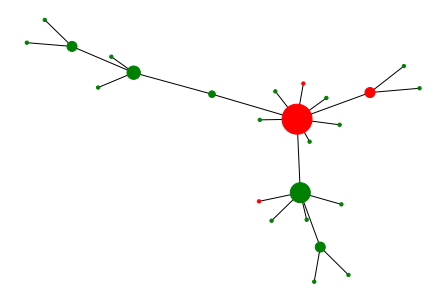

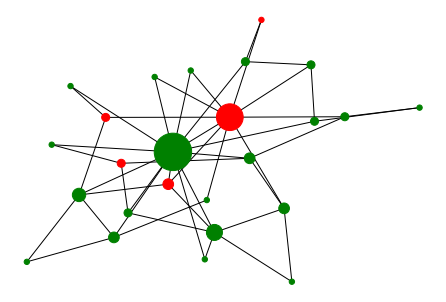

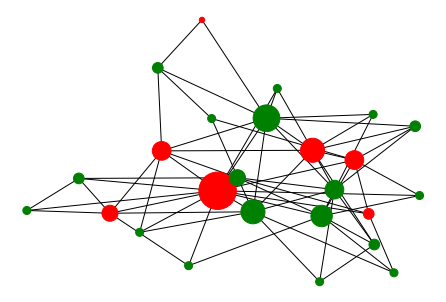

In [43]:
# Tracé des graphes sociaux sur une population plus petite
nb_agents = 25 # 50 est optimal pour le graphe, sinon les tailles sont trop disproportionné

# Choix du type de graphe : 
for i in range(1,4):
    
    graph = nx.barabasi_albert_graph(nb_agents, i)

    matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
    sma = SMA(nb_agents, matrix)

    color_map = []
    for node in graph:
        if sma.malade[node] == 1:
            color_map.append('red')
        else: 
            color_map.append('green')  

    size =  []
    for node in graph:
        size.append(graph.degree(node))

    max_value = np.max(size)
    iterator = 0
    for value in size:
        size[iterator] = (value**2/max_value)*100
        iterator += 1

    my_pos = nx.spring_layout(graph, seed = 100)

    plt.figure()
    nx.draw(graph, pos=my_pos, node_color=color_map, node_size=size)
    plt.axis('off')
    plt.show()

### Partie 3 : Facteurs de contagion <a class="anchor" id="c1-p3"></a>

Explications :

[Table des matières](#tdm)

In [8]:
# Utilisation du graphe dans la classe Agent avec import dans la classe SMA :
class SMA:
    def __init__(self, nb_agents, adjacency_matrix, graphe):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non
        # On récupère le graphe pour travailler dessus dans le modèle de contagion
        self.graphe = graphe

        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[0.90,0.10])[0])

        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        prop_poids = [0.035,0.492,0.323,0.15] 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            
    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 

In [9]:
# Explications sur la manière de récupèrer les alpha-contacts dans la classe Agent
class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

    def decide(self, tick) :
        alpha = 0.8
        if self.has_it:
            # Pour chaque agents j 
            for j in range(0,len(sma.agentList)):
                liens = []
                contact = []
                for i in range(0,len(list(graph.edges(j)))):
                    # print(list(graph.edges(j))[i][1])
                    # On récupère les agents en lien avec notre agent
                    # On les met dans un tableau
                    liens.append(list(graph.edges(j))[i][1])
                print(f"L'agent {j} a {len(liens)} liens")
                print(f"Les liens de l'agent {j} sont : {list(sma.graphe.edges(j))}")
                # On récupère aléatoirement alpha % de ces personnes
                for k in range(int(alpha*len(liens))):
                    print(f"On garde {alpha} % de liens donc : {int(alpha*len(liens))} contact")
                    valeur_contact = random.randint(0,int(alpha*len(liens)))
                    print(f"On récupère la personne {valeur_contact} dans la liste")
                    contact.append(liens.pop(valeur_contact))
                    print(f"Liens après {k} itérations : {liens}")
                    print(f"Contact à {k} itérations : {contact}")
                # On fait en sorte que chaque j agents aient au moins 1 contact :
                if (contact == []):
                    print(f"Comme garder {alpha} % de liens équivaut à {int(alpha*len(liens))} contact, l'agent {j} garde son unique lien.")
                    contact.append(liens[len(liens)-1])
                print(f"Au final, les alpha-contacts de {j} sont : {contact}\n")

In [10]:
# On relance notre expérience 
nb_agents = 5
nb_rounds = 1

# Choix du type de graphe : 
graph = nx.barabasi_albert_graph(nb_agents, 1) 

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix, graph)

# On donne la parole
parole = "J'ai la parole."
an_agent = np.random.choice(sma.agentList)
an_agent.has_it = parole
print(f"Il y a {nb_agents} agents et {nb_rounds} tours.\n")

# On lance le jeu
sma.run(nb_rounds)

Il y a 5 agents et 1 tours.

L'agent 0 a 2 liens
Les liens de l'agent 0 sont : [(0, 1), (0, 3)]
On garde 0.8 % de liens donc : 1 contact
On récupère la personne 0 dans la liste
Liens après 0 itérations : [3]
Contact à 0 itérations : [1]
Au final, les alpha-contacts de 0 sont : [1]

L'agent 1 a 2 liens
Les liens de l'agent 1 sont : [(1, 0), (1, 2)]
On garde 0.8 % de liens donc : 1 contact
On récupère la personne 1 dans la liste
Liens après 0 itérations : [0]
Contact à 0 itérations : [2]
Au final, les alpha-contacts de 1 sont : [2]

L'agent 2 a 2 liens
Les liens de l'agent 2 sont : [(2, 1), (2, 4)]
On garde 0.8 % de liens donc : 1 contact
On récupère la personne 0 dans la liste
Liens après 0 itérations : [4]
Contact à 0 itérations : [1]
Au final, les alpha-contacts de 2 sont : [1]

L'agent 3 a 1 liens
Les liens de l'agent 3 sont : [(3, 0)]
Comme garder 0.8 % de liens équivaut à 0 contact, l'agent 3 garde son unique lien.
Au final, les alpha-contacts de 3 sont : [0]

L'agent 4 a 1 liens
L

### Partie 4 : Simulation avec une contagion aléatoire V1 <a class="anchor" id="c1-p4"></a>

Explications : 

[Table des matières](#tdm)

In [11]:
class SMA:
    def __init__(self, nb_agents, adjacency_matrix, graphe, depart, taux_contact, contamination, deces, guerison, periode_contagion, taux_grave):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non
        self.cas_grave = [] # 1 = Oui, 0 = Non
        
        # On récupère le graphe pour travailler dessus dans le modèle de contagion
        self.graphe = graphe
        self.immunise = [] # 1 = Oui, 0 = Non
        self.jour_malade = []
        
        self.taux_contact = taux_contact # contact
        self.contamination = contamination # contamination
        self.deces = deces # décès
        self.guerison = guerison # guérison
        self.periode_contagion = periode_contagion # période pendant laquelle le patient est malade
        self.taux_grave = taux_grave # selon la gravité, réanimation ou hospitalisation

        # Pour récupérer le nombre de personnes malades par jours 
        self.plot_malade = []
        self.plot_vivant = []
        self.plot_immunise = []
        self.plot_grave = []

        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            self.cas_grave.append(0)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[1-depart,depart])[0])
            if self.malade[i] == 1:
                self.immunise.append(1)
            else:
                self.immunise.append(0)
            self.jour_malade.append(0)

        # Initialisation des paramètres se basant sur les sources :
        # Proportions cumulatives pour l'âge :
        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        # Par tranches d'âges les proportions normalisées sont :
        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        # Proportions pour le poids :
        prop_poids = [0.035,0.492,0.323,0.15]

        # Proportions pour le groupe sanguin : 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

        # On compte le nombre de cas :
        self.plot_malade.append(self.malade.count(1))
        self.plot_immunise.append(self.immunise.count(1))
        self.plot_vivant.append(self.vivant.count(0))
        self.plot_grave.append(self.cas_grave.count(1))


    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            self.plot_malade.append(self.malade.count(1))
            self.plot_immunise.append(self.immunise.count(1))
            self.plot_vivant.append(self.vivant.count(0))
            self.plot_grave.append(self.cas_grave.count(1))

    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 
        #print("\ntick " + str(self.tick) + " ended.\n")

In [12]:
class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

    def decide(self, tick) :
        j = self.id_number

        # On regarde si l'agent malade va guérir ou mourir
        if sma.malade[j] == 1 and sma.vivant[j] == 1:
            if sma.jour_malade[j] <= sma.periode_contagion:
                # Tous les jours, l'agent malade (non cas-grave) peut devenir un cas grave :
                if sma.cas_grave[j] == 0:
                    sma.cas_grave[j] = np.random.choice([0,1], 1, p=[1-sma.taux_grave,sma.taux_grave])[0]

                # Si c'est un cas grave, il peut décéder : 
                if sma.cas_grave[j] == 1:
                    sma.vivant[j] = np.random.choice([0,1], 1, p=[sma.deces,1-sma.deces])[0]

                # Sinon, il peut guérir :
                else: 
                    sma.malade[j] = np.random.choice([0,1], 1, p=[sma.guerison,1-sma.guerison])[0]

                # S'il meurt, il n'est plus malade
                if sma.vivant[j] == 0:
                    sma.malade[j] = 0
                    sma.jour_malade[j] += sma.periode_contagion

                # Quand notre agent n'est plus malade, il est immunisé  
                if sma.malade[j] == 0:
                    sma.jour_malade[j] += sma.periode_contagion
                    sma.immunise[j] = 1
                # Puis, pour chaque malade on compte 1 jour de plus pour ce tour
                sma.jour_malade[j] += 1
        
        # Après la période d'periode_contagion, l'agent n'est plus malade
        if sma.jour_malade[j] > sma.periode_contagion:
            sma.malade[j] = 0
            sma.immunise[j] = 1

        # Si l'agent j est vivant, on regarde s'il peut être contaminé :
        # Donc il faut qu'il soit sain et non immunisé
        if sma.vivant[j] == 1 and sma.immunise[j] == 0 and sma.malade[j] == 0:
            # On regarde tous ces liens et on garde uniquement les contacts
            liens = []
            contact = []
            for i in range(0,len(list(graph.edges(j)))):
                # On récupère les agents en lien avec notre agent
                # On les met dans un tableau
                liens.append(list(graph.edges(j))[i][1])
                # On récupère aléatoirement taux_contact % de ces personnes
            for k in range(int(sma.taux_contact*len(liens))):
                valeur_contact = random.randint(0,int(sma.taux_contact*len(liens)))
                contact.append(liens.pop(valeur_contact))
            # On fait en sorte que chaque j agents aient au moins 1 contact :
            if (contact == []):
                contact.append(liens[len(liens)-1])
            
            # Pour chaque personnes restantes dans les contacts, on regarde si elles sont malades
            for i in range(0,len(contact)):
                if sma.malade[contact[i]] == 1:
                    # Si un contact est malade, il y a contamination % chances de contamination pour notre agent j
                    # La contamination est calculée avec le R0
                    # R0 correspond au nombre de personnes contaminées sur la période de contagion
                    contamination = sma.contamination / (len(contact) * sma.periode_contagion)
                    sma.malade[j] = np.random.choice([0,1], 1, p=[1-contamination,contamination])[0]

Propagation du virus pour 700 agents et 60 jours.

Le temps d'exécution de la simulation est de 1.3258s.


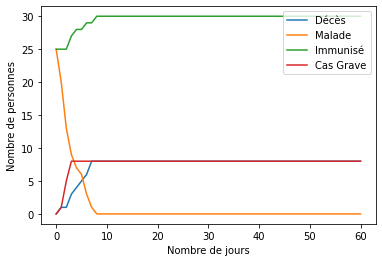

In [13]:
nb_agents = 700
nb_rounds = 60
print(f"Propagation du virus pour {nb_agents} agents et {nb_rounds} jours.")

# Choix du type de graphe : 

graph = nx.barabasi_albert_graph(nb_agents, 1) 
#graph = nx.complete_graph(nb_agents)
#graph = nx.erdos_renyi_graph(nb_agents,0.1)
#graph = nx.cycle_graph(nb_agents)
#graph = nx.random_regular_graph(3,nb_agents)

# Pour tester dans une boucle for : 
graphs = [nx.barabasi_albert_graph(nb_agents, 1), nx.erdos_renyi_graph(nb_agents,0.1), nx.cycle_graph(nb_agents), nx.random_regular_graph(3,nb_agents)]
departs = [0.01, 0.05, 0.1, 0.2, 0.5]
taux_contacts = [0.2, 0.4, 0.6, 0.8]
contaminations = [2,4,8]
decess = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
guerisons = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
periode_contagions = [2,4,6,8,10,12,14,15]


depart = 0.05 # Proportion de personnes contaminées au départ
taux_contact = 0.6 # Taux de contact d'une personne sur tous ces liens
contamination = 2 # R0 : nombre de personnes que contamine un agent
deces = 0.2 # Taux de décès pour la maladie quand une personne est un cas grave
guerison = 0.3 # Taux de guérison de la maladie
periode_contagion = 18 # Période pendant laquelle l'agent est malade
taux_grave = 0.1 # Taux pour lequel une personne malade devient un cas grave

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix, graph, depart, taux_contact, contamination, deces, guerison, periode_contagion, taux_grave)

temps_debut = time.time()
# On lance le jeu
sma.run(nb_rounds)

temps_fin = time.time()
print(f"\nLe temps d'exécution de la simulation est de {round(temps_fin-temps_debut,4)}s.")

# Tracé de graphes :
x = []
for i in range(0,len(sma.plot_vivant)):
    x.append(i)

y = [sma.plot_vivant, sma.plot_malade, sma.plot_immunise, sma.plot_grave]
labels = ['Décès', 'Malade', 'Immunisé', 'Cas Grave']

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)
plt.xlabel('Nombre de jours')
plt.ylabel('Nombre de personnes')
plt.legend(loc="upper right")
#plt.axhline(y=nb_agents,c='black',ls='-')
plt.savefig('./plot/simulation_v1.pdf')
plt.show()

### Partie 5 : Simulation avec une contagion aléatoire V2 (dépendance de l'âge) <a class="anchor" id="c1-p5"></a>

Explications : La différence avec la V1 la différenciation entre le taux de gravité et de décès selon l'âge.

Pour l'instant, si la tranche d'âge est 3, le taux de gravité est de 75% et de décès 89%. 

TO DO : rajouter des tranches d'âge pour être fiable sur nos données de sources.

[Table des matières](#tdm)

In [57]:
class SMA:
    def __init__(self, nb_agents, adjacency_matrix, graphe, depart, taux_contact, contamination, guerison, periode_contagion):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non
        self.cas_grave = [] # 1 = Oui, 0 = Non
        
        # On récupère le graphe pour travailler dessus dans le modèle de contagion
        self.graphe = graphe
        self.immunise = [] # 1 = Oui, 0 = Non
        self.jour_malade = []
        
        self.taux_contact = taux_contact # contact
        self.contamination = contamination # contamination
        self.guerison = guerison # guérison
        self.periode_contagion = periode_contagion # période pendant laquelle le patient est malade

        # Les taux de gravité et décès différent selon la classe d'âge
        self.taux_grave = [] # selon la gravité, réanimation ou hospitalisation
        self.deces = [] # taux décès


        # Pour récupérer le nombre de personnes malades par jours 
        self.plot_malade = []
        self.plot_vivant = []
        self.plot_immunise = []
        self.plot_grave = []

        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            self.cas_grave.append(0)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[1-depart,depart])[0])
            if self.malade[i] == 1:
                self.immunise.append(1)
            else:
                self.immunise.append(0)
            self.jour_malade.append(0)

        # Initialisation des paramètres se basant sur les sources :
        # Proportions cumulatives pour l'âge :
        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        # Par tranches d'âges les proportions normalisées sont :
        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        # Proportions pour le poids :
        prop_poids = [0.035,0.492,0.323,0.15]

        # Proportions pour le groupe sanguin : 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

            
            # On remplit selon l'âge
            # Données démographiques en source :

            hospi_3 = 65/100
            hospi_2 = 30/100
            hospi_1 = 4/100
            hospi_0 = 1/100
            if self.age[i] == 3:
                self.taux_grave.append(hospi_3)
                self.deces.append(0.89)
            if self.age[i] == 2:
                self.taux_grave.append(hospi_2)
                self.deces.append(((1-0.89)*hospi_2)/hospi_3)
            if self.age[i] == 1:
                self.taux_grave.append(hospi_1)
                self.deces.append(((1-0.89)*hospi_1)/hospi_3)
            else:
                self.taux_grave.append(hospi_0)
                self.deces.append(((1-0.89)*hospi_0)/hospi_3)


        # On compte le nombre de cas :
        self.plot_malade.append(self.malade.count(1))
        self.plot_immunise.append(self.immunise.count(1))
        self.plot_vivant.append(self.vivant.count(0))
        self.plot_grave.append(self.cas_grave.count(1))


    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            self.plot_malade.append(self.malade.count(1))
            self.plot_immunise.append(self.immunise.count(1))
            self.plot_vivant.append(self.vivant.count(0))
            self.plot_grave.append(self.cas_grave.count(1))

    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 
        #print("\ntick " + str(self.tick) + " ended.\n")

In [58]:
class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

    def decide(self, tick) :
        j = self.id_number

        # On regarde si l'agent malade va guérir ou mourir
        if sma.malade[j] == 1 and sma.vivant[j] == 1:
            if sma.jour_malade[j] <= sma.periode_contagion:
                # Tous les jours, l'agent malade (non cas-grave) peut devenir un cas grave :
                if sma.cas_grave[j] == 0:
                    sma.cas_grave[j] = np.random.choice([0,1], 1, p=[1-sma.taux_grave[j],sma.taux_grave[j]])[0]

                # Si c'est un cas grave, il peut décéder : 
                if sma.cas_grave[j] == 1:
                    sma.vivant[j] = np.random.choice([0,1], 1, p=[sma.deces[j],1-sma.deces[j]])[0]

                # Sinon, il peut guérir :
                else: 
                    sma.malade[j] = np.random.choice([0,1], 1, p=[sma.guerison,1-sma.guerison])[0]

                # S'il meurt, il n'est plus malade
                if sma.vivant[j] == 0:
                    sma.malade[j] = 0
                    sma.jour_malade[j] += sma.periode_contagion

                # Quand notre agent n'est plus malade, il est immunisé  
                if sma.malade[j] == 0:
                    sma.jour_malade[j] += sma.periode_contagion
                    sma.immunise[j] = 1
                # Puis, pour chaque malade on compte 1 jour de plus pour ce tour
                sma.jour_malade[j] += 1
        
        # Après la période d'periode_contagion, l'agent n'est plus malade
        if sma.jour_malade[j] > sma.periode_contagion:
            sma.malade[j] = 0
            sma.immunise[j] = 1

        # Si l'agent j est vivant, on regarde s'il peut être contaminé :
        # Donc il faut qu'il soit sain et non immunisé
        if sma.vivant[j] == 1 and sma.immunise[j] == 0 and sma.malade[j] == 0:
            # On regarde tous ces liens et on garde uniquement les contacts
            liens = []
            contact = []
            for i in range(0,len(list(graph.edges(j)))):
                # On récupère les agents en lien avec notre agent
                # On les met dans un tableau
                liens.append(list(graph.edges(j))[i][1])
                # On récupère aléatoirement taux_contact % de ces personnes
            for k in range(int(sma.taux_contact*len(liens))):
                valeur_contact = random.randint(0,int(sma.taux_contact*len(liens)))
                contact.append(liens.pop(valeur_contact))
            # On fait en sorte que chaque j agents aient au moins 1 contact :
            if (contact == []):
                contact.append(liens[len(liens)-1])
            
            # Pour chaque personnes restantes dans les contacts, on regarde si elles sont malades
            for i in range(0,len(contact)):
                if sma.malade[contact[i]] == 1:
                    # Si un contact est malade, il y a contamination % chances de contamination pour notre agent j
                    # La contamination est calculée avec le R0
                    # R0 correspond au nombre de personnes contaminées sur la période de contagion
                    contamination = sma.contamination / (len(contact) * sma.periode_contagion)
                    sma.malade[j] = np.random.choice([0,1], 1, p=[1-contamination,contamination])[0]

Propagation du virus pour 200 agents et 120 jours.

Le temps d'exécution de la simulation est de 0.7385s.


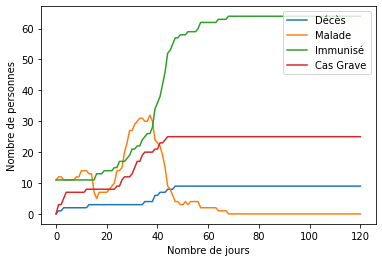

In [59]:
nb_agents = 200
nb_rounds = 120
print(f"Propagation du virus pour {nb_agents} agents et {nb_rounds} jours.")

# Choix du type de graphe : 

graph = nx.barabasi_albert_graph(nb_agents, 1) 
#graph = nx.complete_graph(nb_agents)
#graph = nx.erdos_renyi_graph(nb_agents,0.1)
#graph = nx.cycle_graph(nb_agents)
#graph = nx.random_regular_graph(3,nb_agents)

# Pour tester dans une boucle for : 
graphs = [nx.barabasi_albert_graph(nb_agents, 1), nx.erdos_renyi_graph(nb_agents,0.1), nx.cycle_graph(nb_agents), nx.random_regular_graph(3,nb_agents)]
departs = [0.01, 0.05, 0.1, 0.2, 0.5]
taux_contacts = [0.2, 0.4, 0.6, 0.8]
contaminations = [1,2,4]
guerisons = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]
periode_contagions = [2,4,6,8,10,12,14,15]


depart = 0.05 # Proportion de personnes contaminées au départ
taux_contact = 0.6 # Taux de contact d'une personne sur tous ces liens
contamination = 2 # R0 : nombre de personnes que contamine un agent
guerison = 0.01 # Taux de guérison de la maladie
periode_contagion = 14 # Période pendant laquelle l'agent est malade

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix, graph, depart, taux_contact, contamination, guerison, periode_contagion)

temps_debut = time.time()
# On lance le jeu
sma.run(nb_rounds)

temps_fin = time.time()
print(f"\nLe temps d'exécution de la simulation est de {round(temps_fin-temps_debut,4)}s.")

# Tracé de graphes :
x = []
for i in range(0,len(sma.plot_vivant)):
    x.append(i)

y = [sma.plot_vivant, sma.plot_malade, sma.plot_immunise, sma.plot_grave]
labels = ['Décès', 'Malade', 'Immunisé', 'Cas Grave']

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)
plt.xlabel('Nombre de jours')
plt.ylabel('Nombre de personnes')
plt.legend(loc="upper right")
#plt.axhline(y=nb_agents,c='black',ls='-')
plt.savefig('./plot/simulation_v2.pdf')
plt.show()

### Partie 6 : Algorithme génétique <a class="anchor" id="c1-p6"></a>

[Table des matières](#tdm)

## Chapitre 2 : Graphes <a class="anchor" id="c2"></a>

### Partie 1 : Graphe de l'évolution du Covid en France <a class="anchor" id="c2-p1"></a>

[Table des matières](#tdm)

In [69]:
# Création d'un csv avec les dates de 2020
with open('dates.csv', 'w', newline='') as file:
    writer = csv.writer(file,delimiter=',')
    writer.writerow(["date"])
    mois = [1,2,3,4,5,6,7,8,9,10,11,12]
    for m in mois:
        if m < 8:
            if m == 2:
                for j in range(1,30):
                    writer.writerow([f"{date(2020,m,j)}"])
            else:
                if m % 2 == 0:
                    for j in range(1,31):
                        writer.writerow([f"{date(2020,m,j)}"])
                if m % 2 != 0:
                    for j in range(1,32):
                        writer.writerow([f"{date(2020,m,j)}"])
        else:
            if m % 2 == 0:
                for j in range(1,32):
                    writer.writerow([f"{date(2020,m,j)}"])
            if m % 2 != 0:
                for j in range(1,31):
                    writer.writerow([f"{date(2020,m,j)}"])

In [70]:
# Collecte des données sur le site du gouvernement pour l'année 2020
def collecte_donnees(granularite='national'):
    print("Collecte des données du gouvernement")
    data_brute = pd.read_csv('https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv',low_memory=False)
    dates = pd.read_csv('dates.csv')

    # National
    if granularite == "national":
        data_brute = data_brute.loc[data_brute['source_type'] == "ministere-sante"]
        data_brute = data_brute.loc[data_brute['granularite'] == "pays"].reset_index()
        data_brute = data_brute[['date','cas_confirmes', 'deces', 'deces_ehpad', 'reanimation', 'hospitalises', 'gueris']]
        data_brute = dates.set_index('date').join(data_brute.set_index('date'))
        data = data_brute.interpolate(limit_area='inside')
        data = data.dropna(how='all')
        data['reanimation'][0:3] = 0
        data['gueris'][0:3] = 0

    # Regional
    if granularite == "regional":
        data_brute = data_brute.loc[data_brute['source_type'] == "opencovid19-fr"]
        data_brute = data_brute.loc[data_brute['maille_code'] == "REG-32"].reset_index()
        data_brute = data_brute[['date','cas_confirmes', 'deces','deces_ehpad', 'reanimation', 'hospitalises', 'gueris']]
        data_brute = dates.set_index('date').join(data_brute.set_index('date'))
        data = data_brute.interpolate(limit_area='inside')
        data = data.dropna(how='all')
        data = data.loc['2020-03-18':]

    # Departemental
    if granularite == "departemental":
        data_brute = pd.read_csv(glob.glob('donnees-hospitalieres-covid19-*')[-1], sep=";")
        data_brute = data_brute.loc[data_brute['dep'] == "59"]
        data_brute[data_brute['sexe']==0].groupby(['jour']).sum()
        data = data.drop(columns=['sexe'])

    return data

In [74]:
data = collecte_donnees()

Collecte des données du gouvernement


Collecte des données du gouvernement
Création du graphe


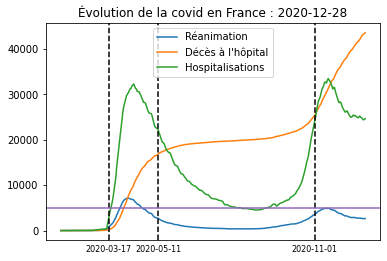

In [4]:
# Création du graphe de l'évolution du Covid en France

# date du jour :
today = date.today()

# Pour avoir toutes les données :
data = collecte_donnees()

# Pour plotter à l'échelle régionale ou départementale :
#data = collecte_donnees('regional')
#data = collecte_donnees('departemental')

print("Création du graphe")
# Plot de la figure : 
fig, ax1 = plt.subplots(1, 1)
ax1.plot(data['reanimation'])
ax1.plot(data['deces'])
ax1.plot(data['hospitalises'])

x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

# Dates importantes :
# début-fin du premier confinement, début-fin été 2020, début du deuxième confinement : 
xcoords = ['2020-03-17','2020-05-11','2020-11-01']

for xc in xcoords:
    plt.axvline(x=xc,ls='--',c='black')
    ax1.text(xc, -0.02, f"{xc}", color='black', transform=ax1.get_xaxis_transform(),
                ha='center', va='top', fontsize=8)

# Nombre de lits en réanimation :
plt.axhline(y=5000,c='tab:purple',ls='-')
plt.title(f"Évolution de la covid en France : {today}")
plt.legend(["Réanimation","Décès à l'hôpital","Hospitalisations"])
plt.savefig(f'./plot/graph_covid.png')
plt.show()

Collecte des données du gouvernement
Création du graphe


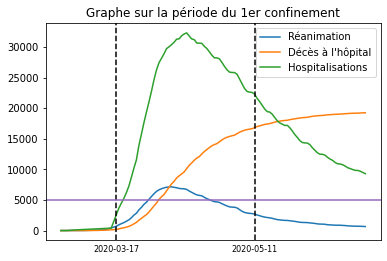

In [11]:
# Création du graphe de l'évolution du Covid en France
# UNIQUEMENT POUR LE CONFINEMENT

# Pour avoir toutes les données :
data = collecte_donnees()

# Pour plotter à l'échelle régionale ou départementale :
#data = collecte_donnees('regional')
#data = collecte_donnees('departemental')

print("Création du graphe")
# Plot de la figure : 
fig, ax1 = plt.subplots(1, 1)
ax1.plot(data['reanimation']['2020-02-24':'2020-06-24'])
ax1.plot(data['deces']['2020-02-24':'2020-06-24'])
ax1.plot(data['hospitalises']['2020-02-24':'2020-06-24'])

x_axis = ax1.axes.get_xaxis()
x_axis.set_visible(False)

# Dates importantes :
# début-fin du premier confinement, début-fin été 2020, début du deuxième confinement : 
xcoords = ['2020-03-17','2020-05-11']

for xc in xcoords:
    plt.axvline(x=xc,ls='--',c='black')
    ax1.text(xc, -0.02, f"{xc}", color='black', transform=ax1.get_xaxis_transform(),
                ha='center', va='top', fontsize=8)

# Nombre de lits en réanimation :
plt.axhline(y=5000,c='tab:purple',ls='-')
plt.title(f"Graphe sur la période du 1er confinement")
plt.legend(["Réanimation","Décès à l'hôpital","Hospitalisations"])
plt.savefig(f'./plot/graph_covid_lockdown.png')
plt.show()

### Partie 2 : Répartition de la population française <a class="anchor" id="c2-p2"></a>

[Table des matières](#tdm)

Répartition de la population française selon les proportions des sources
Création des graphes


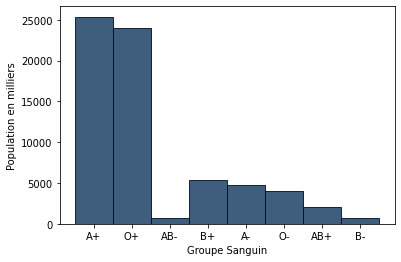

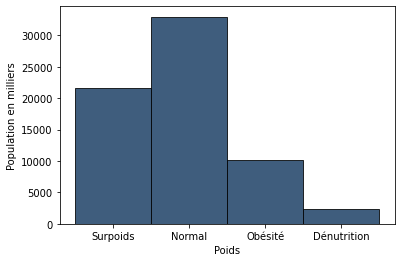

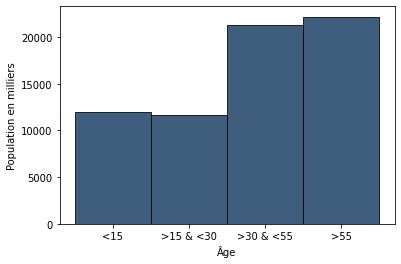

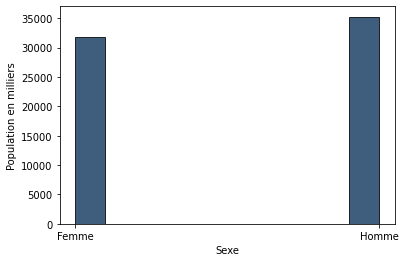

In [7]:
nb_agents = 67_000
age=[]
agentList = []
sexe=[]
poids = []
groupe_sanguin = []

# Proportions cumulatives pour l'âge:
prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

# Par tranches d'âges les proportions normalisées sont :
prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

# Proportions pour le poids :
prop_poids = [0.035,0.492,0.323,0.15]

# Proportions pour le groupe sanguin : 
prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

print("Répartition de la population française selon les proportions des sources")
# Initialize accointances based on the matrix
for i in range(nb_agents):
    agentList.append(i)


for i in range(nb_agents):
    if 0 <= i <= int(nb_agents*prop_age[0]):
        age.append('<15')
        sexe.append(np.random.choice(['Homme','Femme'], 1, p=[prop_homme[0],prop_femme[0]])[0])
    if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
        age.append('>15 & <30')
        sexe.append(np.random.choice(['Homme','Femme'], 1, p=[prop_homme[0],prop_femme[0]])[0])
    if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
        age.append('>30 & <55')
        sexe.append(np.random.choice(['Homme','Femme'], 1, p=[prop_homme[0],prop_femme[0]])[0])
    if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
        age.append('>55')
        sexe.append(np.random.choice(['Homme','Femme'], 1, p=[prop_homme[0],prop_femme[0]])[0])
    poids.append(np.random.choice(['Dénutrition','Normal','Surpoids','Obésité'], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
    groupe_sanguin.append(np.random.choice(['A+','O+','B+','AB+','A-','O-','B-','AB-'], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

print("Création des graphes")

plt.hist(groupe_sanguin, color="#3F5D7D", align='left', bins=range(0,9),edgecolor='black', linewidth=0.8)
plt.xlabel("Groupe Sanguin")
plt.ylabel("Population en milliers")
plt.savefig('./plot/groupe_sanguin.pdf')
plt.show()

plt.hist(poids,color="#3F5D7D", align='left', bins=range(0,5),edgecolor='black', linewidth=0.8)
plt.xlabel("Poids")
plt.ylabel("Population en milliers")
plt.savefig('./plot/poids.pdf')
plt.show()

plt.hist(age,color="#3F5D7D", align='left', bins=range(0,5),edgecolor='black', linewidth=0.8)
plt.xlabel("Âge")
plt.ylabel("Population en milliers")
plt.savefig('./plot/age.pdf')
plt.show()

plt.hist(sexe,color="#3F5D7D", align='mid',edgecolor='black', linewidth=0.8)
plt.xlabel("Sexe")
plt.ylabel("Population en milliers")
plt.savefig('./plot/sexe.pdf')
plt.show()

### Partie 3 : Création d'une animation sur notre graphe social <a class="anchor" id="c2-p3"></a>

[Table des matières](#tdm)

In [9]:
class SMA:
    def __init__(self, nb_agents, adjacency_matrix, graphe, depart, taux_contact, contamination, guerison, periode_contagion):
        self.tick = 0
        self.agentList = []
        self.n_steps = 0
        self.age = []
        self.poids = []
        self.sexe = []
        self.groupe_sanguin = []
        self.vivant = [] # 1 = Oui, 0 = Non
        self.malade = [] # 1 = Oui, 0 = Non
        self.cas_grave = [] # 1 = Oui, 0 = Non
        
        # On récupère le graphe pour travailler dessus dans le modèle de contagion
        self.graphe = graphe
        self.immunise = [] # 1 = Oui, 0 = Non
        self.jour_malade = []
        
        self.taux_contact = taux_contact # contact
        self.contamination = contamination # contamination
        self.guerison = guerison # guérison
        self.periode_contagion = periode_contagion # période pendant laquelle le patient est malade

        # Les taux de gravité et décès différent selon la classe d'âge
        self.taux_grave = [] # selon la gravité, réanimation ou hospitalisation
        self.deces = [] # décès


        # Pour récupérer le nombre de personnes malades par jours 
        self.plot_malade = []
        self.plot_vivant = []
        self.plot_immunise = []
        self.plot_grave = []

        self.nx_animation = [] # Pour récupérer nos graphes sociaux au jour i

        
        # Initialize accointances based on the matrix
        for i in range(nb_agents):
            self.agentList.append(Agent(i, np.nonzero(adjacency_matrix[i])[0]))
            self.vivant.append(1)
            self.cas_grave.append(0)
            # Une probabilité d'être malade pour commencer à tracer les graphes
            self.malade.append(np.random.choice([0,1], 1, p=[1-depart,depart])[0])
            self.immunise.append(0)
            self.jour_malade.append(0)

        # Initialisation des paramètres se basant sur les sources :
        # Proportions cumulatives pour l'âge :
        prop_age = [17.8/100, 35.1242921972263/100, 66.8828069335807/100, 1]

        # Par tranches d'âges les proportions normalisées sont :
        prop_homme = [0.527541666807402, 0.521707530462693, 0.506880352191682, 0.467120912994188]
        prop_femme = [0.472458333192598, 0.478292469537307, 0.493119647808318, 0.532879087005812]

        # Proportions pour le poids :
        prop_poids = [0.035,0.492,0.323,0.15]

        # Proportions pour le groupe sanguin : 
        prop_groupe_sanguin = [0.38,0.36,0.08,0.03,0.07,0.06,0.01,0.01]

        for i in range(nb_agents):
            if 0 <= i <= int(nb_agents*prop_age[0]):
                self.age.append(0)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[0],prop_femme[0]])[0])
            if int(nb_agents*prop_age[0]) < i <= int(nb_agents*prop_age[1]):
                self.age.append(1)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[1],prop_femme[1]])[0])
            if int(nb_agents*prop_age[1]) < i <= int(nb_agents*prop_age[2]):
                self.age.append(2)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[2],prop_femme[2]])[0])
            if int(nb_agents*prop_age[2]) < i <= int(nb_agents*prop_age[3]):   
                self.age.append(3)
                self.sexe.append(np.random.choice([0,1], 1, p=[prop_homme[3],prop_femme[3]])[0])
            self.poids.append(np.random.choice([0,1,2,3], 1, p=[prop_poids[0],prop_poids[1],prop_poids[2],prop_poids[3]])[0])
            self.groupe_sanguin.append(np.random.choice([0,1,2,3,4,5,6,7], 1, p=[prop_groupe_sanguin[0],prop_groupe_sanguin[1],prop_groupe_sanguin[2],prop_groupe_sanguin[3],prop_groupe_sanguin[4],prop_groupe_sanguin[5],prop_groupe_sanguin[6],prop_groupe_sanguin[7]])[0])

            # On remplit selon l'âge
            # Données démographiques en source :

            hospi_3 = 65/100
            hospi_2 = 30/100
            hospi_1 = 4/100
            hospi_0 = 1/100
            if self.age[i] == 3:
                self.taux_grave.append(hospi_3)
                self.deces.append(0.89)
            if self.age[i] == 2:
                self.taux_grave.append(hospi_2)
                self.deces.append(((1-0.89)*hospi_2)/hospi_3)
            if self.age[i] == 1:
                self.taux_grave.append(hospi_1)
                self.deces.append(((1-0.89)*hospi_1)/hospi_3)
            else:
                self.taux_grave.append(hospi_0)
                self.deces.append(((1-0.89)*hospi_0)/hospi_3)

        # On compte le nombre de cas :
        self.plot_malade.append(self.malade.count(1))
        self.plot_immunise.append(self.immunise.count(1))
        self.plot_vivant.append(self.vivant.count(0))
        self.plot_grave.append(self.cas_grave.count(1))


    def run(self, rounds):        
        for i in range(0,rounds):
            self.runOnce()
            self.plot_malade.append(self.malade.count(1))
            self.plot_immunise.append(self.immunise.count(1))
            self.plot_vivant.append(self.vivant.count(0))
            self.plot_grave.append(self.cas_grave.count(1))

    def runOnce(self):
        self.tick += 1
        for agent in self.agentList:
            agent.decide(self.tick) 
        #print("\ntick " + str(self.tick) + " ended.\n")
        self.nx_animation.append(self.draw_graph("Jour_" + str(self.tick)))

    def draw_graph(self,titre):
        color_map = []
        for node in self.graphe:
            if self.malade[node] == 1:
                color_map.append('red')
            else:
                if self.vivant[node] == 0: 
                    color_map.append('grey')  
                else:
                    if self.immunise[node] == 1: 
                        color_map.append('blue')  
                    else:
                        color_map.append('green')

        size = []
        for node in self.graphe:
            size.append(self.graphe.degree(node))

        max_value = np.max(size)
        iterator = 0
        for value in size:
            size[iterator] = (value/max_value)*400
            iterator += 1

        my_pos = nx.spring_layout(graph, seed = 100)
        fig = plt.figure()
        plt.axis('off')
        nx.draw(self.graphe,pos=my_pos, node_color=color_map, node_size=size)
        plt.title(str(titre))
        plt.savefig(f'./plot/{titre}.png')
        # print(f"{titre} sauvegardé")
        plt.close(fig)
        return fig

In [10]:
class Agent:
    def __init__(self, id_number, accointances) :
        self.id_number = id_number
        self.accointances = accointances
        self.has_it = False

    def decide(self, tick) :
        j = self.id_number

        # On regarde si l'agent malade va guérir ou mourir
        if sma.malade[j] == 1 and sma.vivant[j] == 1:
            if sma.jour_malade[j] <= sma.periode_contagion:
                # Tous les jours, l'agent malade (non cas-grave) peut devenir un cas grave :
                if sma.cas_grave[j] == 0:
                    sma.cas_grave[j] = np.random.choice([0,1], 1, p=[1-sma.taux_grave[j],sma.taux_grave[j]])[0]

                # Si c'est un cas grave, il peut décéder : 
                if sma.cas_grave[j] == 1:
                    sma.vivant[j] = np.random.choice([0,1], 1, p=[sma.deces[j],1-sma.deces[j]])[0]

                # Sinon, il peut guérir :
                else: 
                    sma.malade[j] = np.random.choice([0,1], 1, p=[sma.guerison,1-sma.guerison])[0]

                # S'il meurt, il n'est plus malade
                if sma.vivant[j] == 0:
                    sma.malade[j] = 0
                    sma.jour_malade[j] += sma.periode_contagion

                # Quand notre agent n'est plus malade, il est immunisé  
                if sma.malade[j] == 0:
                    sma.jour_malade[j] += sma.periode_contagion
                    sma.immunise[j] = 1
                # Puis, pour chaque malade on compte 1 jour de plus pour ce tour
                sma.jour_malade[j] += 1
        
        # Après la période d'periode_contagion, l'agent n'est plus malade
        if sma.jour_malade[j] > sma.periode_contagion:
            sma.malade[j] = 0
            sma.immunise[j] = 1

        # Si l'agent j est vivant, on regarde s'il peut être contaminé :
        # Donc il faut qu'il soit sain et non immunisé
        if sma.vivant[j] == 1 and sma.immunise[j] == 0 and sma.malade[j] == 0:
            # On regarde tous ces liens et on garde uniquement les contacts
            liens = []
            contact = []
            for i in range(0,len(list(graph.edges(j)))):
                # On récupère les agents en lien avec notre agent
                # On les met dans un tableau
                liens.append(list(graph.edges(j))[i][1])
                # On récupère aléatoirement taux_contact % de ces personnes
            for k in range(int(sma.taux_contact*len(liens))):
                valeur_contact = random.randint(0,int(sma.taux_contact*len(liens)))
                contact.append(liens.pop(valeur_contact))
            # On fait en sorte que chaque j agents aient au moins 1 contact :
            if (contact == []):
                contact.append(liens[len(liens)-1])
            
            # Pour chaque personnes restantes dans les contacts, on regarde si elles sont malades
            for i in range(0,len(contact)):
                if sma.malade[contact[i]] == 1:
                    # Si un contact est malade, il y a contamination % chances de contamination pour notre agent j
                    # La contamination est calculée avec le R0
                    # R0 correspond au nombre de personnes contaminées sur la période de contagion
                    contamination = sma.contamination / (len(contact) * sma.periode_contagion)
                    sma.malade[j] = np.random.choice([0,1], 1, p=[1-contamination,contamination])[0]

Suppression des graphes déjà existant
Propagation du virus pour 300 agents et 60 jours.
Création des plots pour les graphes sociaux

Le temps d'exécution de la simulation est de 21.9598s.


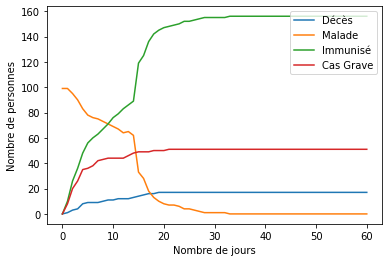

In [11]:
# Pour la création de graphe sociaux il faut prendre un nombre d'agents et de jours plus faible
nb_agents = 300
nb_rounds = 60

# Choix du type de graphe : 
graph = nx.barabasi_albert_graph(nb_agents, 1) 
#graph = nx.complete_graph(nb_agents)
#graph = nx.erdos_renyi_graph(nb_agents,0.1)
#graph = nx.cycle_graph(nb_agents)
#graph = nx.random_regular_graph(3,nb_agents)

depart = 0.33 # Proportion de personnes contaminées au départ
taux_contact = 0.4 # Taux de contact d'une personne sur tous ces liens
contamination = 2 # R0 : nombre de personnes que contamine un agent
guerison = 0.1 # Taux de guérison de la maladie
periode_contagion = 14 # Période pendant laquelle l'agent est malade

matrix = nx.to_numpy_array(graph, nodelist=range(nb_agents))
sma = SMA(nb_agents, matrix, graph, depart, taux_contact, contamination, guerison, periode_contagion)

# On regarde si des fichiers existe déjà 
if os.path.exists("./plot/Jour_0.png"):
    print("Suppression des graphes déjà existant")
    iterator = 0
    while (os.path.exists(f"./plot/Jour_{iterator}.png")):
        os.remove(f"./plot/Jour_{iterator}.png")
        iterator += 1

temps_debut = time.time()
print(f"Propagation du virus pour {nb_agents} agents et {nb_rounds} jours.")
print("Création des plots pour les graphes sociaux")
sma.nx_animation.append(sma.draw_graph("Jour_0"))
# On lance le jeu
sma.run(nb_rounds)

temps_fin = time.time()
print(f"\nLe temps d'exécution de la simulation est de {round(temps_fin-temps_debut,4)}s.")

# Tracé de graphes :
x = []
for i in range(0,len(sma.plot_vivant)):
    x.append(i)

y = [sma.plot_vivant, sma.plot_malade, sma.plot_immunise, sma.plot_grave]
labels = ['Décès', 'Malade', 'Immunisé', 'Cas Grave']

for y_arr, label in zip(y, labels):
    plt.plot(x, y_arr, label=label)
plt.xlabel('Nombre de jours')
plt.ylabel('Nombre de personnes')
plt.legend(loc="upper right")
#plt.axhline(y=nb_agents,c='black',ls='-')
plt.savefig('./plot/simulation_gif.png')
plt.show()

In [12]:
# Création du gif :
frames = []
duration = 0.5*nb_agents
imgs = glob.glob("./plot/J*.png")
for i in range(0,len(imgs)):
    new_frame = Image.open(f"./plot/Jour_{i}.png")
    frames.append(new_frame)

frames[0].save('./plot/networkx.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=600, loop=0)

### Sources <a class="anchor" id="s"></a>

[Table des matières](#tdm)

Utilisation de la mémoire dans une classe en Python :
https://habr.com/en/post/458518/ 

Réduction de la mémoire dans un dataset :
https://www.kaggle.com/gemartin/load-data-reduce-memory-usage

Réduction de la mémoire dans un array numpy : https://pythonspeed.com/articles/numpy-memory-footprint/

Population française selon l'age et le sexe en 2020 : https://www.insee.fr/fr/statistiques/2381474

Obésite en France en 2012 : https://www.roche.fr/fr/innovation-recherche-medicale/decouverte-scientifique-medicale/cardio-metabolisme/enquete-nationale-obepi-2012.html

Groupes sanguins en France : https://www.ints.fr/SangTransfGrSanguin.aspx

Gravité des cas selon les tranches d'âges et le sexe : https://www.hcsp.fr/Explore.cgi/avisrapportsdomaine?clefr=904

Données démographique covid-19 France : https://dc-covid.site.ined.fr/fr/donnees/france/